In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split

%matplotlib inline

In [2]:
# Hyperparmeters
batch_size = 64
learning_rate = 0.003

# Other constants
input_size = 28*28
num_classes = 10

In [3]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
device = get_default_device()

In [4]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b, c in self.dl: 
            yield b.to(self.device), c.to(self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [5]:
dataset = datasets.FashionMNIST(root='data/', train=True, transform=transforms.ToTensor())

train_ds, val_ds = random_split(dataset, [50000, 10000])
train_loader = DeviceDataLoader(DataLoader(train_ds, batch_size, shuffle=True), device)
val_loader = DeviceDataLoader(DataLoader(val_ds, batch_size, shuffle=True), device)

test_ds = datasets.FashionMNIST(root='data/', train=False, transform=transforms.ToTensor())
test_loader = DeviceDataLoader(DataLoader(test_ds, batch_size), device)

In [6]:
len(train_ds), len(val_ds), len(test_ds)

(50000, 10000, 10000)

5


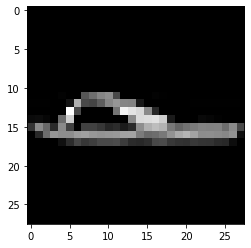

In [13]:
image, label = train_ds[0]
print(label)
plt.imshow(image.permute(1, 2, 0), cmap='gray')
plt.show()

1


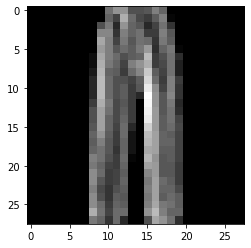

In [14]:
image, label = val_ds[0]
print(label)
plt.imshow(image.permute(1, 2, 0), cmap='gray')
plt.show()

9


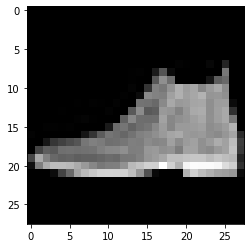

In [16]:
image, label = test_ds[0]
print(label)
plt.imshow(image.permute(1, 2, 0), cmap='gray')
plt.show()

In [6]:
class FashionMnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, xb):        
        xb = xb.view(xb.size(0), -1)        # Flatten the image tensors      
        out = F.relu(self.fc1(xb))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        out = self.fc4(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return loss, acc

In [7]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [8]:
model = FashionMnistModel().to(device)

In [9]:
training_losses, val_losses, val_acc = [], [], []
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func) -> None:   
    for epoch in range(epochs): 
        running_loss = 0
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad() 
            running_loss += loss.item()  
        training_losses.append(running_loss / len(train_loader))
                    
        # Validation phase
        with torch.no_grad():
            losses, accs = 0, 0
            for batch in val_loader:
                loss, acc = model.validation_step(batch)
                losses += loss.item()
                accs += acc.item()
            val_losses.append(losses / len(val_loader))
            val_acc.append(accs / len(val_loader))
        
        print("Epoch {}/{}".format(epoch+1, epochs),
             "Train_loss {:.4f}".format(training_losses[epoch]),
             "Val_loss {:.4f}".format(val_losses[epoch]),
             "Val_acc {:.4f}".format(val_acc[epoch]))

In [11]:
fit(20, learning_rate, model, train_loader, val_loader, optimizer)

Epoch 1/20 Train_loss 0.5436 Val_loss 0.3953 Val_acc 0.8610
Epoch 2/20 Train_loss 0.3902 Val_loss 0.4093 Val_acc 0.8496
Epoch 3/20 Train_loss 0.3558 Val_loss 0.3642 Val_acc 0.8692
Epoch 4/20 Train_loss 0.3285 Val_loss 0.3606 Val_acc 0.8684
Epoch 5/20 Train_loss 0.3150 Val_loss 0.3404 Val_acc 0.8831
Epoch 6/20 Train_loss 0.3008 Val_loss 0.3318 Val_acc 0.8835
Epoch 7/20 Train_loss 0.2881 Val_loss 0.3170 Val_acc 0.8842
Epoch 8/20 Train_loss 0.2766 Val_loss 0.3357 Val_acc 0.8775
Epoch 9/20 Train_loss 0.2676 Val_loss 0.3209 Val_acc 0.8860
Epoch 10/20 Train_loss 0.2562 Val_loss 0.3373 Val_acc 0.8855
Epoch 11/20 Train_loss 0.2531 Val_loss 0.3373 Val_acc 0.8854
Epoch 12/20 Train_loss 0.2449 Val_loss 0.3671 Val_acc 0.8730
Epoch 13/20 Train_loss 0.2418 Val_loss 0.3304 Val_acc 0.8901
Epoch 14/20 Train_loss 0.2346 Val_loss 0.3504 Val_acc 0.8859
Epoch 15/20 Train_loss 0.2293 Val_loss 0.3300 Val_acc 0.8909
Epoch 16/20 Train_loss 0.2258 Val_loss 0.3667 Val_acc 0.8824
Epoch 17/20 Train_loss 0.2221 Val

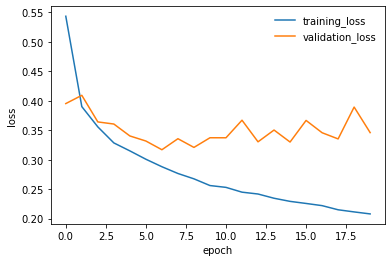

In [12]:
plt.plot(training_losses, label='training_loss')
plt.plot(val_losses, label='validation_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(frameon=False)

## Overfitting & Dropout

![https://cdn-images-1.medium.com/max/1200/1*iWQzxhVlvadk6VAJjsgXgg.png]

In [11]:
class FashionMnistModel_dp(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, xb):        
        xb = xb.view(xb.size(0), -1)        # Flatten the image tensors      
        out = self.dropout(F.relu(self.fc1(xb)))
        out = self.dropout(F.relu(self.fc2(out)))
        out = self.dropout(F.relu(self.fc3(out)))
        out = self.fc4(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return loss, acc

In [12]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func) -> None:   
    for epoch in range(epochs): 
        running_loss = 0
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad() 
            running_loss += loss.item()  
        training_losses.append(running_loss / len(train_loader))
                    
        # Validation phase
        with torch.no_grad():
            model.eval()
            
            losses, accs = 0, 0
            for batch in val_loader:
                loss, acc = model.validation_step(batch)
                losses += loss.item()
                accs += acc.item()
            val_losses.append(losses / len(val_loader))
            val_acc.append(accs / len(val_loader))
            
        model.train()
        
        print("Epoch {}/{}".format(epoch+1, epochs),
             "Train_loss {:.4f}".format(training_losses[epoch]),
             "Val_loss {:.4f}".format(val_losses[epoch]),
             "Val_acc {:.4f}".format(val_acc[epoch]))

In [20]:
model_dp = FashionMnistModel_dp().to(device)

In [21]:
training_losses, val_losses, val_acc = [], [], []
optimizer = torch.optim.Adam(model_dp.parameters(), lr=learning_rate)

In [22]:
fit(20, learning_rate, model_dp, train_loader, val_loader, optimizer)

Epoch 1/20 Train_loss 0.6100 Val_loss 0.4360 Val_acc 0.8425
Epoch 2/20 Train_loss 0.4616 Val_loss 0.3984 Val_acc 0.8540
Epoch 3/20 Train_loss 0.4239 Val_loss 0.3754 Val_acc 0.8678
Epoch 4/20 Train_loss 0.4086 Val_loss 0.3841 Val_acc 0.8638
Epoch 5/20 Train_loss 0.3894 Val_loss 0.3801 Val_acc 0.8670
Epoch 6/20 Train_loss 0.3811 Val_loss 0.3510 Val_acc 0.8764
Epoch 7/20 Train_loss 0.3724 Val_loss 0.3515 Val_acc 0.8674
Epoch 8/20 Train_loss 0.3630 Val_loss 0.3604 Val_acc 0.8779
Epoch 9/20 Train_loss 0.3591 Val_loss 0.3490 Val_acc 0.8753
Epoch 10/20 Train_loss 0.3559 Val_loss 0.3482 Val_acc 0.8756
Epoch 11/20 Train_loss 0.3493 Val_loss 0.3542 Val_acc 0.8799
Epoch 12/20 Train_loss 0.3433 Val_loss 0.3369 Val_acc 0.8828
Epoch 13/20 Train_loss 0.3448 Val_loss 0.3448 Val_acc 0.8818
Epoch 14/20 Train_loss 0.3416 Val_loss 0.3586 Val_acc 0.8682
Epoch 15/20 Train_loss 0.3377 Val_loss 0.3479 Val_acc 0.8750
Epoch 16/20 Train_loss 0.3307 Val_loss 0.3373 Val_acc 0.8794
Epoch 17/20 Train_loss 0.3312 Val

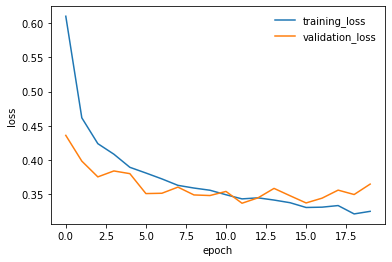

In [23]:
plt.plot(training_losses, label='training_loss')
plt.plot(val_losses, label='validation_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(frameon=False)

## Prediction

In [17]:
def predict_image(img, model):
    xb = img.unsqueeze(0).to(device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 9 , Predicted: 9


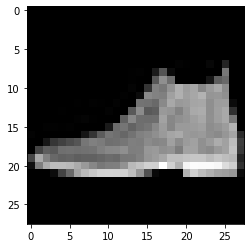

In [18]:
img, label = test_ds[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model_dp))

Label: 5 , Predicted: 5


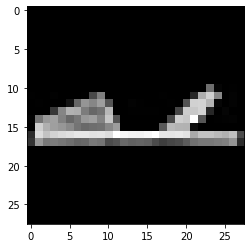

In [19]:
img, label = test_ds[111]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model_dp))